# This is a pipeline to visualize and analyze the results of CellProfiler on inmunohistochemistry experiments done for PH3


#### TODO:
    - register an a2axai14 line to ARA to separate territories in the ToS
    - register the projections from AUD1 to select the area
    - implement significance
    - decide how to select d1 vs d2 (test clustering)

In [1]:
# Import stuff
%load_ext autoreload
%autoreload 2
import os
from utils import data_reader
from utils import plot_utils
from utils import generic_functions as gf
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
#from ggplot import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import dill
from IPython.display import clear_output
from datetime import date
clear_output()

In [2]:
# Indicate the animal IDs you want to load
animals_to_load = ['PH301', 'PH302', 'PH303', 'PH304', 'PH305', 'PH306', 'PH308', 'PH310']
animals_to_load = ['PH312']
# Indicate the main path where all processed data is
processed_data_path = '/mnt/c/Users/herny/Desktop/SWC/Data/Microscopy_Data/Plasticity/PH3_inmuno/Processed_data/'
processed_data_path = '/home/hernandom/data/Microscopy_Data/Plasticity/PH3_inmuno/Processed_data/'

In [6]:
if len(animals_to_load) > 1:
    output_directory = processed_data_path
else:
    output_directory = os.path.join(processed_data_path, animals_to_load[0], 'Analysis')
    if not os.path.exists(output_directory):
        os.mkdir(output_directory)

In [4]:
# loop through the animals to get the dataset
df_list = []
for animal_to_load in animals_to_load:
# get paths
    data_path = os.path.join(processed_data_path, animal_to_load)
    # path where the dataframe is (the output of CellProfiler)
    CPoutput_path = os.path.join(data_path, 'Cell_profiler_output/')
    # Import the data
    df_list.append(data_reader.PH3_data_reader(CPoutput_path))

In [ ]:
# concatenate data frames
df = pd.concat(df_list, ignore_index=True)

In [ ]:
# Create a unique identifier for every instance of measure (manual ROI)
df['group_name'] = df.apply(gf.group_name, axis=1)
df['manual_roi_name'] = df.apply(gf.manual_roi_name, axis=1)

In [ ]:
# Add the data path as an attribute of the dataframe
df.attrs['datapath'] = processed_data_path

In [ ]:
# save it
df.to_pickle(os.path.join(output_directory, '-'.join(animals_to_load) + '_df.pkl'))

In [ ]:
# Print output for report
print('Date of analysis:', date.today())
print('Output folder:', output_directory)

In [7]:
# read it
df = pd.read_pickle(os.path.join(output_directory, '-'.join(animals_to_load) + '_df.pkl'))
# Add the data path as an attribute of the dataframe because it might have changed computers
df.attrs['datapath'] = processed_data_path

In [ ]:
# Rename channels
#df = df.rename(columns={"Children_FinalDots_C2_Count": "drd2_count",
#                        "Children_FinalDots_C3_Count": "drd1_count"})

In [ ]:
#OPTIONAL

# Remove some manual ROIs that are not good
g_names_to_remove = ['PH301-1-5-R-Tail']

df = df[~df.manual_roi_name.isin(g_names_to_remove)]

In [ ]:
df

***
### Sanity checks on the data
***

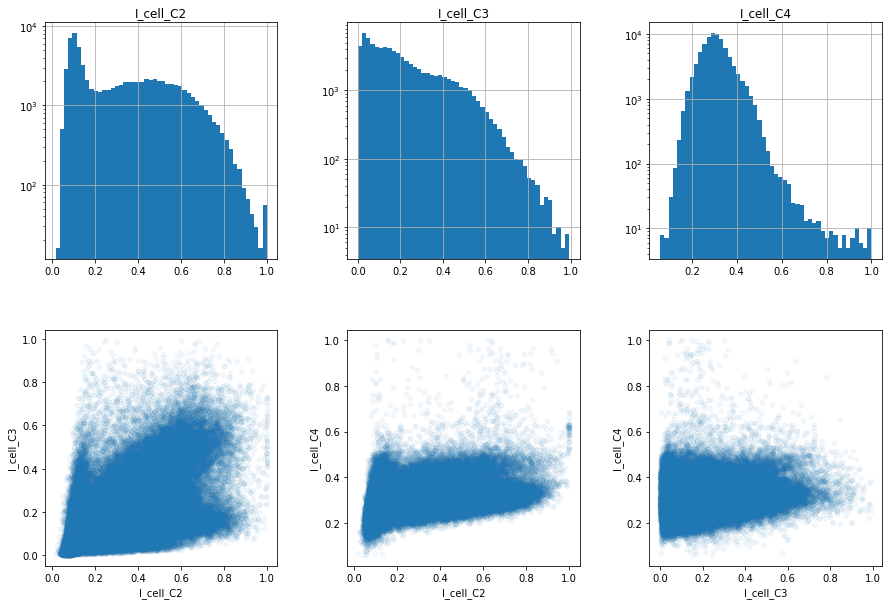

In [8]:
# plot histograms of counts for all the cells
channels = ["I_cell_C2", "I_cell_C3", "I_cell_C4"]
%matplotlib inline
fig, axs = plt.subplots(2, ncols=3, sharey=False, figsize=(15,10))
axs = axs.ravel()
axArr = [axs[0], axs[1], axs[2]]
i = 0
for axis in axArr:
    df.hist(channels[i], ax = axis, bins=50)
    #sns.distplot(df[channels[i]], ax = axis)
    axis.set_yscale("log")
    #axis.set_ylim(0,1000)
    axis.set_title(channels[i])
    i+=1
df.plot.scatter(channels[0], channels[1], ax = axs[3], alpha = 0.05)
df.plot.scatter(channels[0], channels[2], ax = axs[4], alpha = 0.05)
df.plot.scatter(channels[1], channels[2], ax = axs[5], alpha = 0.05)
plt.show()

#### Steps:
- Select SPNs from cellpose
    - Select D1 and D2 from cellpose classification
    - Identify PH3 positive cells

Outputs:
- Quantify the proportion of PH3+ D1 and D2
- Locations of PH3 cells with three categories: D1, D2, spn

### - Select SPNs, from cellpose

In [9]:
SPN_indexes_cp = df[df.cellpose_SPN > 0].index.values

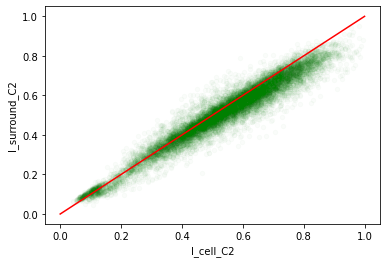

In [10]:
df.loc[SPN_indexes_cp].plot.scatter("I_cell_C2", "I_surround_C2", alpha = 0.02, color='green')
plt.plot([0, 1], [0, 1], '-r')
plt.show()

/home/hernandom/.conda/envs/imageanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


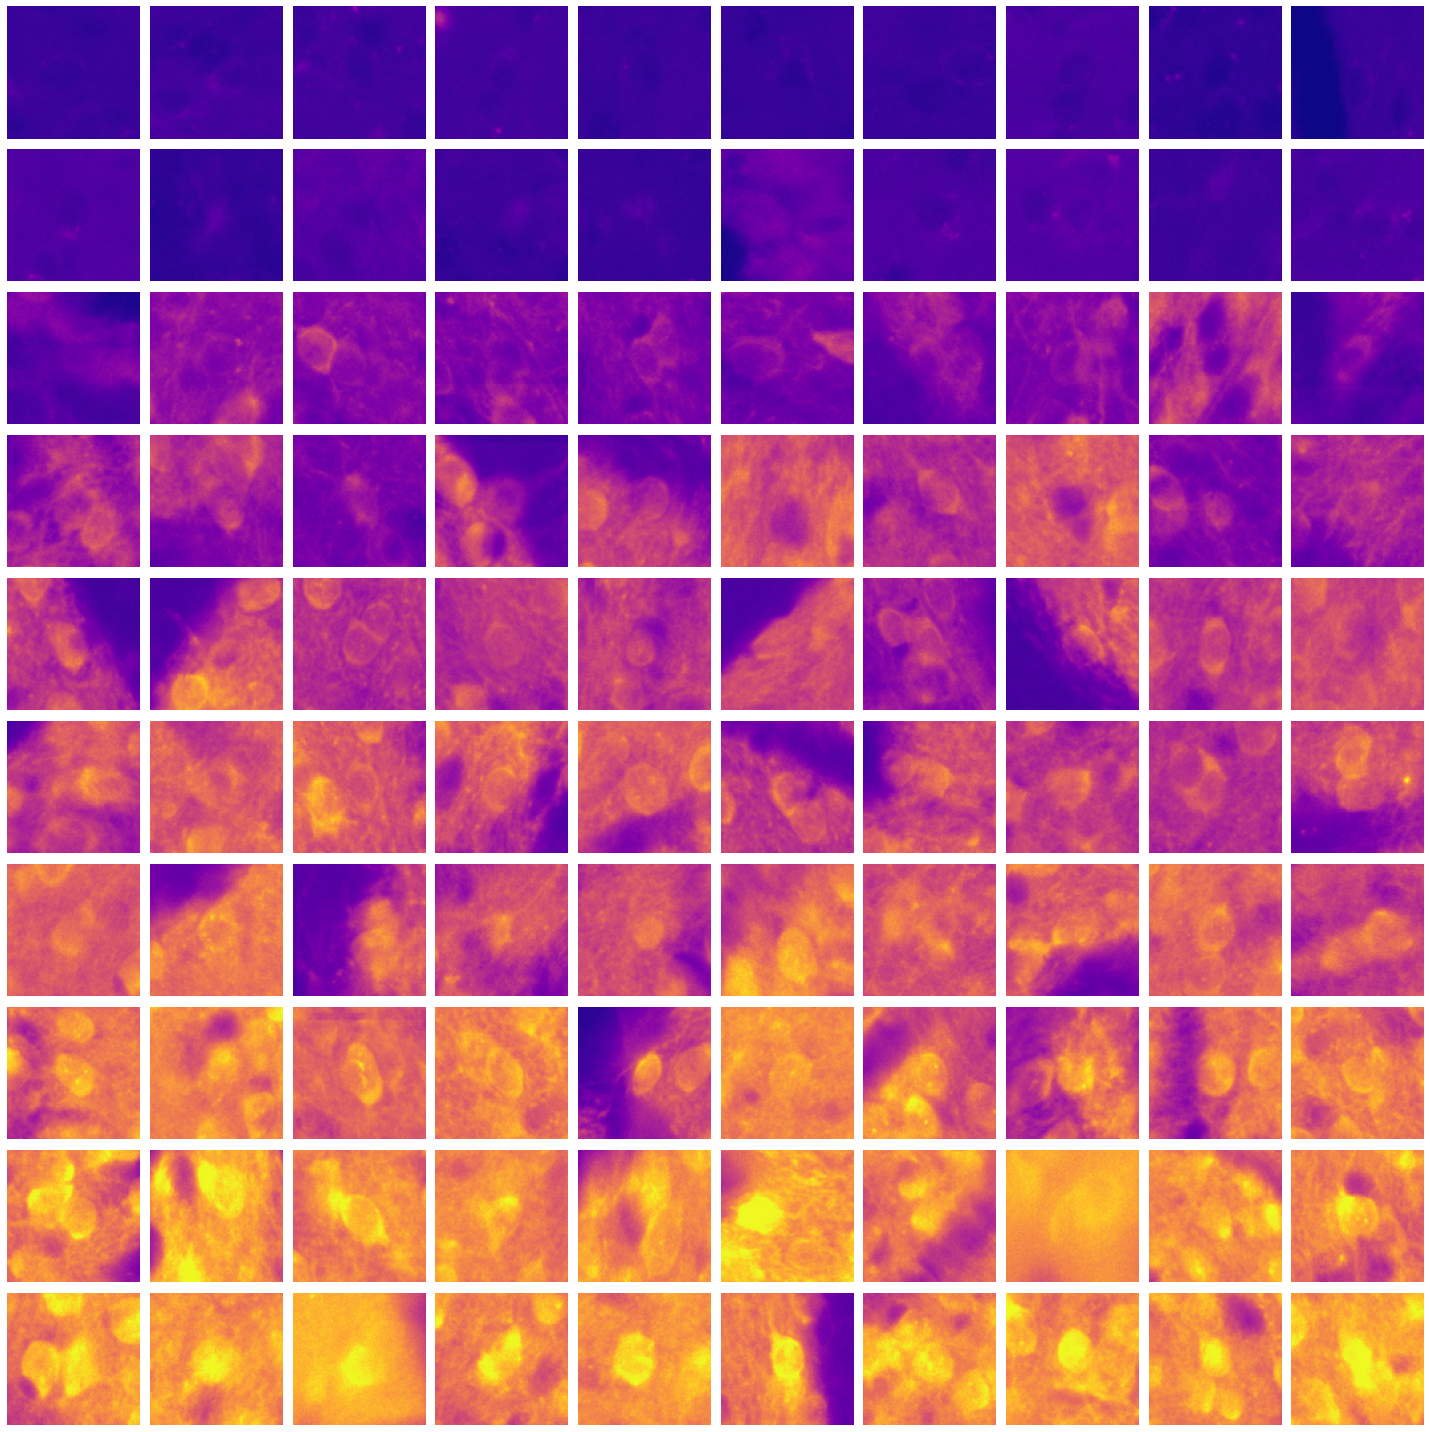

In [11]:
# plot just one channel
channel = 2
ncells = 10
sc = 'I_cell_C' + str(channel)
# plot randomly sets of cells within certain values of channel 2, which is DARPP-32
thresholds = ((0, .1), (.1, .2), (.2, .3), (.3, .4), (.4, .5),
              (.5, .6), (.6, .7), (.7, .8), (.8, 9), (.9, 1))
# get indexes to plot
indexes = gf.get_indexes_by_thr(df.loc[SPN_indexes_cp], sc, thresholds, ncells)
# plot
fig, axs = plt.subplots(len(thresholds), ncells, sharey=False, figsize=(np.ceil(2*ncells), np.ceil(2*len(thresholds))))
fig = plot_utils.plot_channel_of_indexes(fig, axs, indexes, df, channel, window=60, lut='plasma')
fig.show()

In [13]:
# remove low intensity ones
c2_thr = .4
# find indexes of those cells
SPN_indexes_thr = df[df.I_cell_C2 >= c2_thr].index.values
SPN_indexes = np.intersect1d(SPN_indexes_cp, SPN_indexes_thr)
print('Threshold for SPNs: {}    Number of SPNs: {}'.format(c2_thr, df.loc[SPN_indexes].shape[0]))

Threshold for SPNs: 0.4    Number of SPNs: 9853


### - Select d1 and d2 separately

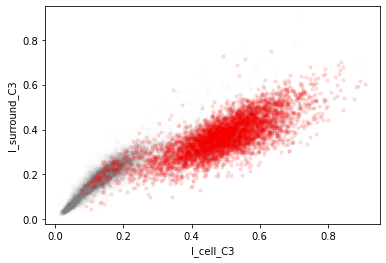

In [14]:
# d2 from cellpose
d2_indexes_cp = df[df.cellpose_d2 > 0].index.values
d2_spn_idx = np.intersect1d(SPN_indexes, d2_indexes_cp)
df.loc[SPN_indexes].plot.scatter("I_cell_C3", "I_surround_C3", alpha = 0.01, color ='grey')
plt.plot(df.loc[d2_spn_idx].I_cell_C3, df.loc[d2_spn_idx].I_surround_C3, '.r', alpha=0.1)

In [ ]:
# now cluster the cells based on density
from sklearn.cluster import DBSCAN

clust = DBSCAN(eps=0.5, min_samples=1000)
X = df.loc[d2_spn_idx][['I_cell_C3', 'I_surround_C3']]
X = X.to_numpy().astype("float32", copy = False)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
clust.fit(X)

In [ ]:
# clustering results
fig, ax = plt.subplots(1,1, figsize=(12, 5))
colors = ['grey', 'green', 'red']
for klass, color in zip(range(0, 2), colors[1:]):
    ax.plot(X[clust.labels_ == klass, 0], X[clust.labels_ == klass, 1],
               color=color, marker='.', alpha=0.3, linewidth=0)
ax.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
ax.set_xlabel('tdTomato intensity inside')
ax.set_ylabel('tdTomato intensity surround')

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
X = df.loc[SPN_indexes][['I_cell_C3', 'I_surround_C3']]
X = X.to_numpy().astype("float32", copy = False)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
gmm = GMM(n_components=2).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=4, alpha=0.02);

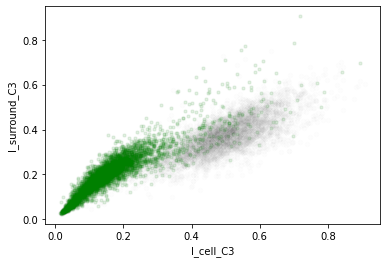

In [15]:
# d1 from cellpose
d1_spn_idx = np.setdiff1d(SPN_indexes, d2_indexes_cp)
df.loc[SPN_indexes].plot.scatter("I_cell_C3", "I_surround_C3", alpha = 0.01, color ='grey')
plt.plot(df.loc[d1_spn_idx].I_cell_C3, df.loc[d1_spn_idx].I_surround_C3, '.g', alpha=0.1)

In [ ]:
clust = DBSCAN(eps=0.4, min_samples=1000)
X = df.loc[d1_spn_idx][['I_cell_C3', 'I_surround_C3']]
X = X.to_numpy().astype("float32", copy = False)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
clust.fit(X)

In [ ]:
# clustering results
fig, ax = plt.subplots(1,1, figsize=(12, 5))
colors = ['grey', 'green', 'red']
for klass, color in zip(range(0, 2), colors[1:]):
    ax.plot(X[clust.labels_ == klass, 0], X[clust.labels_ == klass, 1],
               color=color, marker='.', alpha=0.3, linewidth=0)
ax.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
ax.set_xlabel('tdTomato intensity inside')
ax.set_ylabel('tdTomato intensity surround')

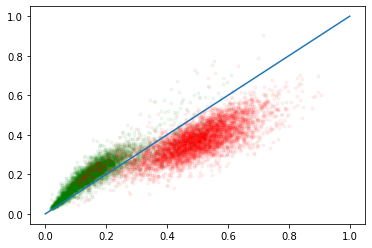

In [16]:
#both
plt.plot(df.loc[d1_spn_idx].I_cell_C3, df.loc[d1_spn_idx].I_surround_C3, '.g', alpha=0.05)
plt.plot(df.loc[d2_spn_idx].I_cell_C3, df.loc[d2_spn_idx].I_surround_C3, '.r', alpha=0.05)
plt.plot([0, 1], [0, 1])

In [ ]:
# see the d2 ones above the diagonal
test_idx = np.intersect1d(d2_spn_idx, df[df.I_surround_C3 > df.I_cell_C3].index.values)
# see the d1 ones below the diagonal
test_idx = np.intersect1d(d1_spn_idx, df[df.I_surround_C3 <= df.I_cell_C3].index.values)


ncells = 50
shuffledIdx = df.loc[test_idx].index.values.copy()
# shuffle them
np.random.shuffle(shuffledIdx)
shuffledIdx = shuffledIdx[0:ncells]
fig = plt.subplots(sharey=False, figsize=(15,np.ceil(2*ncells)))
for counter, i in enumerate(shuffledIdx):
    CellImage = plot_utils.plotPH3Cell(df.loc[i], os.path.join(processed_data_path, df.loc[i].AnimalID),
                                       window=60, lut='plasma')
    plt.subplot(ncells, 1, counter+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(CellImage)


In [17]:
# Option 1: stick with cellpose findings
d1_SPN_indexes = d1_spn_idx
d2_SPN_indexes = d2_spn_idx
print('Selecting d1 and d2 just from cellpose')

Selecting d1 and d2 just from cellpose


In [ ]:
# Option 2: select those selected by cellpose and that are above/below the diagonal
d2_SPN_indexes = np.setdiff1d(d2_spn_idx, df[df.I_surround_C3 > df.I_cell_C3].index.values)
d1_SPN_indexes = np.setdiff1d(d1_spn_idx, df[df.I_surround_C3 <= df.I_cell_C3].index.values)
print('Selecting d1 and d2 from cellpose and above / below the diagonal')

In [ ]:
#plot both
plt.plot(df.loc[d1_SPN_indexes].I_cell_C3, df.loc[d1_SPN_indexes].I_surround_C3, '.g', alpha=0.05)
plt.plot(df.loc[d2_SPN_indexes].I_cell_C3, df.loc[d2_SPN_indexes].I_surround_C3, '.r', alpha=0.05)
plt.plot([0, 1], [0, 1])

In [ ]:
# see the d1 cells
channel = 3
ncells = 10
sc = 'I_cell_C' + str(channel)
# plot randomly sets of cells within certain values 
thresholds = ((0, .1), (.1, .2), (.2, .3), (.3, .4), (.4, .5), (.7,1))
# get indexes to plot
indexes = gf.get_indexes_by_thr(df.loc[d1_SPN_indexes], sc, thresholds, ncells)
# plot
fig, axs = plt.subplots(len(thresholds), ncells, sharey=False, figsize=(np.ceil(2*ncells), np.ceil(2*len(thresholds))))
fig = plot_utils.plot_channel_of_indexes(fig, axs, indexes, df, channel, window=60, lut='plasma')
fig.show()

/home/hernandom/.conda/envs/imageanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


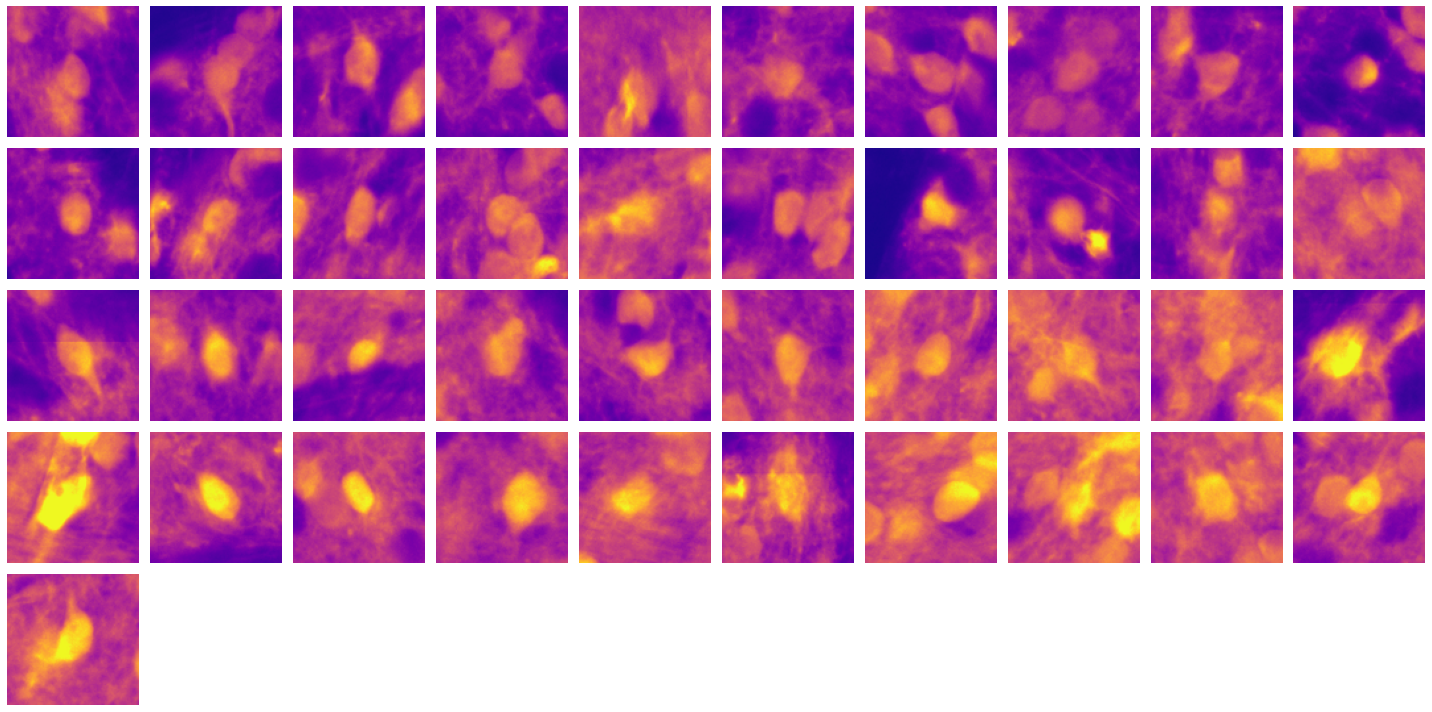

In [18]:
# see the d2 cells
channel = 3
ncells = 10
sc = 'I_cell_C' + str(channel)
# plot randomly sets of cells within certain values of channel 2, which is DARPP-32
thresholds = ((.5, .6), (.6, .7), (.7, .8), (.8, .9), (.9, 1))
# get indexes to plot
indexes = gf.get_indexes_by_thr(df.loc[d2_SPN_indexes], sc, thresholds, ncells)
# plot
fig, axs = plt.subplots(len(thresholds), ncells, sharey=False, figsize=(np.ceil(2*ncells), np.ceil(2*len(thresholds))))
fig = plot_utils.plot_channel_of_indexes(fig, axs, indexes, df, channel, window=60, lut='plasma')
fig.show()

### - Identify PH3+ cells

In [ ]:
# select only cells from one slice
# df_bu = df.copy()
# df = df[df.Slide == '1']
# d1_SPN_indexes = np.intersect1d(d1_SPN_indexes, df.index)
# d2_SPN_indexes = np.intersect1d(d2_SPN_indexes, df.index)
# SPN_indexes = np.intersect1d(SPN_indexes, df.index)

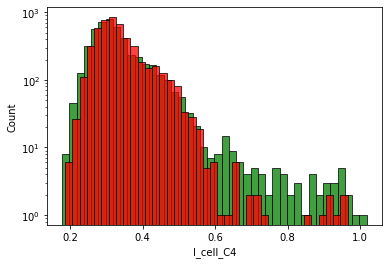

In [19]:
# plot the profiles of the d1 and d2 over the ph3 intensity
splot = sns.histplot(data=df.loc[d1_SPN_indexes], x='I_cell_C4', color='green', binwidth=.02)
sns.histplot(data=df.loc[d2_SPN_indexes], x='I_cell_C4', color='red', binwidth=.02)
SPN_undetermined = SPN_indexes[np.logical_and(~np.in1d(SPN_indexes, d1_SPN_indexes), ~np.in1d(SPN_indexes, d2_SPN_indexes))]
# sns.histplot(data=df.loc[SPN_undetermined], x='I_cell_C4', color='grey', binwidth=.02)
splot.set(yscale="log")
plt.show()

In [ ]:
# see the undetermined cells
ncells = 10
shuffledIdx = df.loc[SPN_undetermined][df.loc[SPN_undetermined].I_cell_C4 > 0.9].index.values.copy()
# shuffle them
np.random.shuffle(shuffledIdx)
shuffledIdx = shuffledIdx[0:ncells]
fig = plt.subplots(sharey=False, figsize=(15,np.ceil(2*ncells)))
for counter, i in enumerate(shuffledIdx):
    CellImage = plot_utils.plotPH3Cell(df.loc[i], os.path.join(processed_data_path, df.loc[i].AnimalID),
                                       window=60, lut='plasma')
    plt.subplot(ncells, 1, counter+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(CellImage)

In [ ]:
# THIS NORMALIZATION STEP WILL REMOVE THOSE CELLS THAT ARE NOT SELECTED AS D1 OR D2
# They can get selected back if needed
print('Running normalization')
# Normalize the data as the tdTomato channel might be leaking into the PH3 one
df['I_cell_C4_norm'] = np.nan
df.at[d2_SPN_indexes, 'I_cell_C4_norm'] = df.loc[d2_SPN_indexes].I_cell_C4 - np.median(df.loc[d2_SPN_indexes].I_cell_C4)
df.at[d1_SPN_indexes, 'I_cell_C4_norm'] = df.loc[d1_SPN_indexes].I_cell_C4 - np.median(df.loc[d1_SPN_indexes].I_cell_C4)

In [ ]:
# NOT RUNNING THE NORMALIZATION
print('NOT Running normalization')
df['I_cell_C4_norm'] = np.nan
df.at[d2_SPN_indexes, 'I_cell_C4_norm'] = df.loc[d2_SPN_indexes].I_cell_C4
df.at[d1_SPN_indexes, 'I_cell_C4_norm'] = df.loc[d1_SPN_indexes].I_cell_C4

In [ ]:
splot = sns.histplot(data=df.loc[d1_SPN_indexes], x='I_cell_C4_norm', color='green', binwidth=.02)
sns.histplot(data=df.loc[d2_SPN_indexes], x='I_cell_C4_norm', color='red', binwidth=.02)
SPN_undetermined = SPN_indexes[np.logical_and(~np.in1d(SPN_indexes, d1_SPN_indexes), ~np.in1d(SPN_indexes, d2_SPN_indexes))]
# sns.histplot(data=df.loc[SPN_undetermined], x='I_cell_C4_norm', color='grey', binwidth=.02)
splot.set(yscale="log")
plt.show()

In [ ]:
# An alternative is to select those cells that are above X sd
mu_d1 = np.mean(df.loc[d1_SPN_indexes].I_cell_C4)
std_d1 = np.std(df.loc[d1_SPN_indexes].I_cell_C4)
mu_d2 = np.mean(df.loc[d2_SPN_indexes].I_cell_C4)
std_d2 = np.std(df.loc[d2_SPN_indexes].I_cell_C4)

sns.histplot(data=df.loc[d1_SPN_indexes], x='I_cell_C4', color='green', binwidth=.01, kde=False, log_scale=(False,False))
sns.histplot(data=df.loc[d2_SPN_indexes], x='I_cell_C4', color='red', binwidth=.01, kde=False, log_scale=(False,False))
plt.axvline(mu_d1 + 4 * std_d1, color='green')
plt.axvline(mu_d2 + 4 * std_d2, color='red')

In [ ]:
# define parameters for selection of ph3 cells
c4_point = [0.7, 0.65]
c4_slope = .95
xs = np.linspace(np.min(df.I_cell_C4_norm), np.max(df.I_cell_C4_norm), 10)

zero_int = c4_point[1] - c4_point[0] * c4_slope

ys = zero_int + xs * c4_slope

df.loc[SPN_indexes].plot.scatter("I_cell_C4_norm", "I_surround_C4", alpha = 0.050)
plt.plot(c4_point[0], c4_point[1], '.r')
# plt.plot([c4_point[0], np.max(df.I_cell_C4_norm)],
#          [c4_point[1], zero_int + np.max(df.I_cell_C4_norm) * c4_slope],
#          '-', color='orange')
plt.plot([c4_point[0], c4_point[0]],
         [np.min(df.I_surround_C4), c4_point[1]],
         '-', color='orange')
plt.plot(xs, ys, color='orange')
plt.show()

In [ ]:
### CLEAN ALL THIS


# apply the selection
# find indexes of PH3 cells
PH3_indexes_all = df[np.logical_and(df.I_cell_C4_norm >= c4_point[0], (df.I_cell_C4_norm * c4_slope + zero_int) >= df.I_surround_C4)].index.values
PH3_indexes = np.intersect1d(SPN_indexes, PH3_indexes_all)
df.loc[PH3_indexes].shape

In [ ]:
# double check
df.loc[SPN_indexes].plot.scatter("I_cell_C4_norm", "I_surround_C4", alpha = 0.050)
plt.plot(df.loc[PH3_indexes].I_cell_C4_norm, df.loc[PH3_indexes].I_surround_C4, '.g')
plt.show()

In [ ]:
# plot just one channel
channel = 4
ncells = 10
sc = 'I_cell_C' + str(channel)
# plot randomly sets of cells within certain values of channel 2, which is DARPP-32
thresholds = ((.75, .8), (.8, 9), (.9, .95), (.95, 1))
# get indexes to plot
indexes = gf.get_indexes_by_thr(df.loc[PH3_indexes], sc, thresholds, ncells)
# plot
fig, axs = plt.subplots(len(thresholds), ncells, sharey=False, figsize=(np.ceil(2*ncells), np.ceil(2*len(thresholds))))
fig = plot_utils.plot_channel_of_indexes(fig, axs, indexes, df, channel, window=60, lut='plasma')
fig.show()

In [ ]:
# total number of PH3 cells
print("There are {} SPN PH3+ cells".format(len(PH3_indexes)))
# total number of d1+ PH3 cells
d1_SPN_PH3_indexes = np.intersect1d(PH3_indexes, d1_SPN_indexes)
print("There are {} d1 + cells".format(len(d1_SPN_PH3_indexes)))
# total number of d2+ PH3 cells
d2_SPN_PH3_indexes = np.intersect1d(PH3_indexes, d2_SPN_indexes)
print("There are {} d2 + cells".format(len(d2_SPN_PH3_indexes)))

# TODO: show enrichment. Normalize by total number of cells selected

In [ ]:
# plot some of the d1 cells
ncells = 10
shuffledIdx = df.loc[d1_SPN_PH3_indexes].index.values.copy()
# shuffle them
np.random.shuffle(shuffledIdx)
shuffledIdx = shuffledIdx[0:ncells]
fig = plt.subplots(sharey=False, figsize=(15,np.ceil(2*ncells)))
for counter, i in enumerate(shuffledIdx):
    CellImage = plot_utils.plotPH3Cell(df.loc[i], os.path.join(processed_data_path, df.loc[i].AnimalID),
                                       window=60, lut='plasma')
    plt.subplot(ncells, 1, counter+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(CellImage)

In [ ]:
# plot some of the d2 cells
ncells = 10
shuffledIdx = df.loc[d2_SPN_PH3_indexes].index.values.copy()
# shuffle them
np.random.shuffle(shuffledIdx)
shuffledIdx = shuffledIdx[0:ncells]
fig = plt.subplots(sharey=False, figsize=(15,np.ceil(2*ncells)))
for counter, i in enumerate(shuffledIdx):
    CellImage = plot_utils.plotPH3Cell(df.loc[i], os.path.join(processed_data_path, df.loc[i].AnimalID),
                                       window=60, lut='plasma')
    plt.subplot(ncells, 1, counter+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(CellImage)

### Save results

In [ ]:
# save the dataframe with the SPN information to calculate, grouping mice together,
# the ph3 positive cells that are d1 or d2 (normalization would have to be done per mouse)
# create columns
df['SPN'] = 0
df.at[SPN_indexes, 'SPN'] = 1
df['d1'] = 0
df.at[d1_SPN_indexes, 'd1'] = 1
df['d2'] = 0
df.at[d2_SPN_indexes, 'd2'] = 1
df['PH3'] = 0
df.at[PH3_indexes, 'PH3'] = 1
# save indexes for going back if necessary
df['df_indexes'] = df.index.values

df.to_pickle(os.path.join(output_directory, '-'.join(animals_to_load) + '_all_cells.pkl'))

In [ ]:
# make a dataframe with only the ph3 for plotting them in the atlas
df_ph3 = df.loc[PH3_indexes]
# create new column
df_ph3['cell_label'] = 'undetermined'
df_ph3.at[PH3_indexes, 'cell_label'] = 'spn'
df_ph3.at[d1_SPN_PH3_indexes, 'cell_label'] = 'd1'
df_ph3.at[d2_SPN_PH3_indexes, 'cell_label'] = 'd2'

In [ ]:
# get the ARA location of the cells, in millimeters
for idx in df_ph3.index:
    ARA_location = gf.register_cell_to_ARA(df_ph3.loc[idx], df_ph3.attrs['datapath'])
    df_ph3.at[idx, 'ARA_ap'] = ARA_location[0]
    df_ph3.at[idx, 'ARA_dv'] = ARA_location[1]
    df_ph3.at[idx, 'ARA_ml'] = ARA_location[2] # this coordinate is flipped

In [ ]:
# save relevant information for Fiji macro (see Fiji Custom repo - Display_points_in_ARA_mm.ijm)
# subselect dataframe
df_tr = df_ph3[['ARA_ap', 'ARA_dv', 'ARA_ml', 'cell_label', 'df_indexes']]
# save output as csv
df_tr.to_csv(os.path.join(output_directory, '-'.join(animals_to_load) + '_ph3_cells_ARA_coordinates.csv'),
             index=False)

In [ ]:
# save dataframe
df_ph3.to_pickle(os.path.join(output_directory, '-'.join(animals_to_load) + '_ph3_cells.pkl'))

In [ ]:
# save the workspace
dill.dump_session(os.path.join(output_directory, '-'.join(animals_to_load) + '.db'))

# transform to a report using this:
convertion_string = 'jupyter nbconvert --to html --no-input '+\
                os.path.join(os.path.abspath(''), 'Inmuno_4channels_analysis.ipynb') +\
                ' --output ' + os.path.join(output_directory, '-'.join(animals_to_load)) + '.html'
os.system(convertion_string)
clear_output()


## Significance

In [ ]:
# calculate the significance of finding these biases for d1
# for each mouse, draw cells randomly from the spn population and compute the p value

In [4]:
# load dataframes here TODO
# Indicate the animal IDs you want to load
animals_to_load = ['PH308', 'PH310', 'PH309', 'PH312']
# Indicate the main path where all processed data is
processed_data_path = '/home/hernandom/data/Microscopy_Data/Plasticity/PH3_inmuno/Processed_data/'

In [6]:
# loop through the animals to get the dataset
df_list = []
for animal_to_load in animals_to_load:
# get paths
    output_directory = os.path.join(processed_data_path, animal_to_load, 'Analysis')
    # read it
    df = pd.read_pickle(os.path.join(output_directory, animal_to_load + '_all_cells.pkl'))
    # Add the data path as an attribute of the dataframe because it might have changed computers
    df.attrs['datapath'] = processed_data_path
    # append
    df_list.append(df)
# concatenate data frames
df = pd.concat(df_list, ignore_index=True)

In [8]:
# load the initial dataset
first_batch_df = pd.read_pickle(os.path.join(processed_data_path, 'PH301-PH302-PH303-PH304-PH305-PH306_all_cells.pkl'))

In [10]:
# concatenate data frames
df = pd.concat([df, first_batch_df], ignore_index=True)

In [12]:
# random iterations to calculate random distribution of proportions
nboot = 1000
# initialize list to save the p_values
pval_list = []

# iterate through the animals
for an_id in df.AnimalID.unique():
    # subset the dataframe
    an_spn_df = df[np.logical_and(df.SPN==1, df.AnimalID==an_id)].reset_index()
    # number of ph3 cells
    n_ph3 = an_spn_df.PH3.sum()
    # initiate array to store random proportions
    rand_prop_list = np.zeros(nboot)
    # iterate
    for i in range(nboot):
        # random sample of cells
        sub_df = an_spn_df.sample(n_ph3)
        # append the proportion of d1 cells to the list
        rand_prop_list[i] = sub_df.d1.mean()

    # mean and std of distribution of random proportions
    rp_mu = np.mean(rand_prop_list)
    rp_std = np.std(rand_prop_list)
    # real proportion of d1 ph3 cells for this animal
    obs_value = an_spn_df[an_spn_df.PH3==1].d1.mean()
    # calculate the z score
    z_val = (obs_value - rp_mu) / rp_std
    # calculate the p value
    p_val = norm.sf(abs(z_val))
    # append to list
    pval_list.append(p_val)

#### Proportion of cells

In [13]:
all_sub = df[df.SPN==1].groupby(['AnimalID'])['d1', 'd2'].mean()
all_sub = all_sub.reset_index()
all_sub = all_sub.melt(id_vars=["AnimalID"], 
                       var_name="cell type", 
                       value_name="proportion")

/home/hernandom/.conda/envs/imageanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [14]:
ph3_sub = df[df.PH3==1].groupby(['AnimalID'])['d1', 'd2'].mean()
ph3_sub = ph3_sub.reset_index()
ph3_sub = ph3_sub.melt(id_vars=["AnimalID"], 
                       var_name="cell type", 
                       value_name="proportion")

/home/hernandom/.conda/envs/imageanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [15]:
all_sub['dataset'] = 'all cells'
ph3_sub['dataset'] = 'ph3 cells'
bp_df = pd.concat([all_sub, ph3_sub])

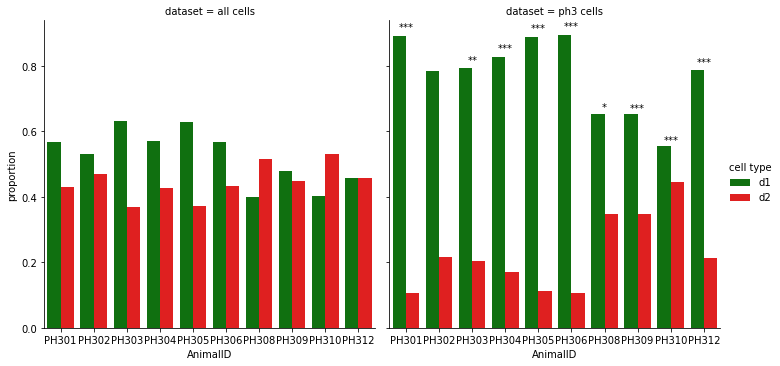

1 asterisks: pval < 0.05
2 asterisks: pval < 0.01
3 asterisks: pval < 0.001


In [27]:
sns.set_palette(['green','red'])
fg_fig = sns.catplot(data=bp_df, x='AnimalID', y='proportion', hue='cell type', col='dataset', kind='bar')
# TODO: add the statistical test
# define three levels of significance for the plotting
sig_levels = [0.05, 0.01, 0.001]
# get the axis of where the significance needs to be
sig_ax = fg_fig.axes[0][1]
# get the y position of where the significance labels need to be
yvals = 6 * [0.8] # TODO!!!!
# draw the asterisks
for i, an in enumerate(bp_df.AnimalID.unique()):
    n_ast = sum(pval_list[i] < sig_levels)
    ast_str = n_ast * '*'
    sub_bd_df = bp_df[np.logical_and(bp_df.AnimalID == an, bp_df['cell type']=='d1')]
    yval = sub_bd_df[sub_bd_df.dataset == 'ph3 cells'].proportion * 1.03
    sig_ax.text(i, yval, ast_str, horizontalalignment='center', verticalalignment='center')

plt.savefig(processed_data_path + 'Proportion_bar-graph.pdf', transparent=True, bbox_inches='tight')
plt.show()

for i,s in enumerate(sig_levels):
    print(i+1, 'asterisks: pval <', s)



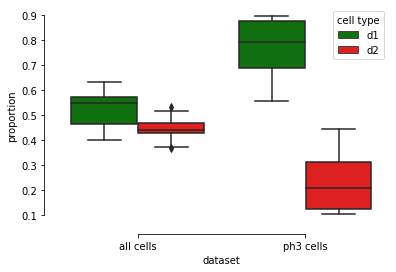

In [28]:
# Draw a nested boxplot
sns.boxplot(x="dataset", y="proportion",
            hue="cell type",# palette=["m", "g"],
            data=bp_df)
sns.despine(offset=10, trim=True)
plt.savefig(processed_data_path + 'Proportion_nested_boxplot.pdf', transparent=True, bbox_inches='tight')
plt.show()

#### Number of cells

/home/hernandom/.conda/envs/imageanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/home/hernandom/.conda/envs/imageanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


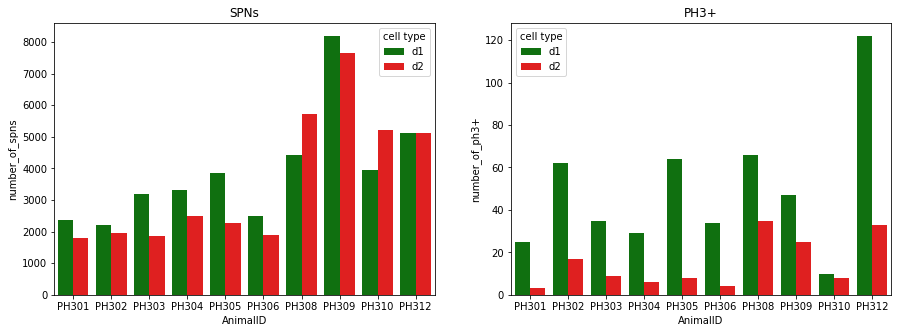

In [35]:
all_sub = df[df.SPN==1].groupby(['AnimalID'])['d1', 'd2'].sum()
all_sub = all_sub.reset_index()
all_sub = all_sub.melt(id_vars=["AnimalID"], 
                       var_name="cell type", 
                       value_name="number_of_spns")

ph3_sub = df[df.PH3==1].groupby(['AnimalID'])['d1', 'd2'].sum()
ph3_sub = ph3_sub.reset_index()
ph3_sub = ph3_sub.melt(id_vars=["AnimalID"], 
                       var_name="cell type", 
                       value_name="number_of_ph3+")

all_sub['dataset'] = 'all cells'
ph3_sub['dataset'] = 'ph3 cells'

sns.set_palette(['green','red'])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.barplot(x='AnimalID', y='number_of_spns', hue='cell type', data=all_sub, ax=ax1)
sns.barplot(x='AnimalID', y='number_of_ph3+', hue='cell type', data=ph3_sub, ax=ax2)
ax1.set_title('SPNs')
ax2.set_title('PH3+')

plt.savefig(processed_data_path + 'Number_bar-graph.pdf', transparent=True, bbox_inches='tight')
plt.show()

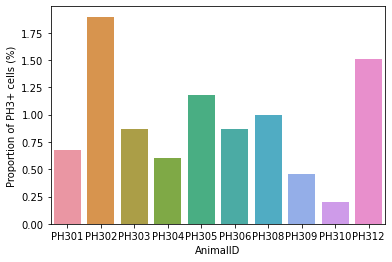

In [54]:
mixed_df = all_sub.merge(ph3_sub, on=['AnimalID', 'cell type']).groupby(['AnimalID']).sum()
mixed_df = mixed_df.reset_index()
mixed_df['proportion'] = mixed_df['number_of_ph3+'] / mixed_df['number_of_spns'] * 100
ax = sns.barplot(x='AnimalID', y='proportion', data=mixed_df)
ax.set(ylabel='Proportion of PH3+ cells (%)')
plt.savefig(processed_data_path + 'Proportion_of_ph3.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [45]:
mixed_df

number_of_spns  number_of_ph3+  proportion
AnimalID                                            
PH301               4137              28    0.006768
PH302               4164              79    0.018972
PH303               5072              44    0.008675
PH304               5816              35    0.006018
PH305               6119              72    0.011767
PH306               4388              38    0.008660
PH308              10147             101    0.009954
PH309              15851              72    0.004542
PH310               9181              18    0.001961
PH312              10266             155    0.015098

In [ ]:
fg_fig = sns.catplot(data=mixed_df, x='AnimalID', y='proportion', hue='cell type', col='dataset', kind='bar')

In [40]:
bp_df

AnimalID cell type  proportion    dataset
0     PH301        d1    0.568770  all cells
1     PH302        d1    0.530019  all cells
2     PH303        d1    0.631506  all cells
3     PH304        d1    0.571871  all cells
4     PH305        d1    0.627880  all cells
5     PH306        d1    0.566317  all cells
6     PH308        d1    0.399548  all cells
7     PH309        d1    0.479873  all cells
8     PH310        d1    0.401381  all cells
9     PH312        d1    0.458099  all cells
10    PH301        d2    0.431230  all cells
11    PH302        d2    0.469981  all cells
12    PH303        d2    0.368494  all cells
13    PH304        d2    0.428129  all cells
14    PH305        d2    0.372120  all cells
15    PH306        d2    0.433683  all cells
16    PH308        d2    0.517073  all cells
17    PH309        d2    0.448878  all cells
18    PH310        d2    0.531079  all cells
19    PH312        d2    0.458099  all cells
0     PH301        d1    0.892857  ph3 cells
1     PH302        d1    0.784810  ph3 cells
2     PH303        d1    0.795455  ph3 cells
3     PH304        d1    0.828571  ph3 cells
4     PH305        d1    0.888889  ph3 cells
5     PH306        d1    0.894737  ph3 cells
6     PH308        d1    0.653465  ph3 cells
7     PH309        d1    0.652778  ph3 cells
8     PH310        d1    0.555556  ph3 cells
9     PH312        d1    0.787097  ph3 cells
10    PH301        d2    0.107143  ph3 cells
11    PH302        d2    0.215190  ph3 cells
12    PH303        d2    0.204545  ph3 cells
13    PH304        d2    0.171429  ph3 cells
14    PH305        d2    0.111111  ph3 cells
15    PH306        d2    0.105263  ph3 cells
16    PH308        d2    0.346535  ph3 cells
17    PH309        d2    0.347222  ph3 cells
18    PH310        d2    0.444444  ph3 cells
19    PH312        d2    0.212903  ph3 cells

In [ ]:
# deprecated:

## Now run Histology_to_ARA repo scripts for registration (deprecated)

### TODO: Use this to select the cells based on where they are located (e.g. tail of str auditory area)


In [ ]:
# There is no sign of the gradient for now. Wait to do more experiments with the controls

In [ ]:
# read the dataframe
df = pd.read_pickle(os.path.join(processed_data_path, '-'.join(animals_to_load) + '_all_cells.pkl'))
SPN_indexes = df[df.SPN == 1].index.values
d1_SPN_indexes = df[df.d1 == 1].index.values
d2_SPN_indexes = df[df.d2 == 1].index.values
PH3_indexes = df[df.PH3 == 1].index.values

In [ ]:
plt.plot(df.loc[d1_spn_idx].I_cell_C3, df.loc[d1_spn_idx].I_surround_C3, '.g', alpha=0.05)
plt.plot(df.loc[d2_spn_idx].I_cell_C3, df.loc[d2_spn_idx].I_surround_C3, '.r', alpha=0.05)
plt.plot([0, 1], [0, 1])

In [ ]:
df_tosave = df.loc[SPN_indexes][['']]

In [ ]:
df_tosave.to_pickle('/home/hernandom/Desktop/for_Joaquin.pkl')

In [ ]:
def plot_results(X, Y_, means, covariances):
    fig, ax = plt.subplots()
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 3, color=color, alpha=.1)
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color='red')
        # ell.set_clip_box(plt.bbox)
        ell.set_alpha(0.3)
        ax.add_artist(ell)
        plt.xticks(())
        plt.yticks(())

In [ ]:
# Gaussian fit from Joaquin
from sklearn.mixture import GaussianMixture
import itertools
import matplotlib as mpl

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])
X = df_tosave.loc[df_tosave.d2==1, ["I_cell_C3", "I_surround_C3"]].to_numpy()
gmm = GaussianMixture(n_components=1, random_state=0).fit(X)
plot_results(X=X, Y_=gmm.predict(X), means=gmm.means_, covariances=gmm.covariances_)

In [ ]:
np.linalg.eigh(gmm.covariances_)

### explore and visualize data

In [ ]:
df_ph3.iloc[10]

In [ ]:
# Concatenate all the ROIs from one manual slice and show the identified cells

# set the conditions to get the data of one of the ROIs
sel_animal = 'PH308'
sel_slide = '1'
sel_slice = '8'
sel_side = 'Both'
sel_ap = 'Caudoputamen'

sel_mroi_name = '-'.join([sel_animal, sel_slide, sel_slice, sel_side, sel_ap])

# regenerate the picture from the square ROIs
im = plot_utils.get_concat_image_from_rois(df_raw=df, indexes_to_plot=PH3_indexes, sel_mroi_name=sel_mroi_name,
                                           channel=4, cir_radius=80, binning=10, tdtomato_thr=-1,
                                           data_path=processed_data_path)
im

In [ ]:
# Circle all cells in a ROI
g_name = 'PH308-2-8-Both-Caudoputamen-33'
# indicate the size of the circle
cir_radius = 80

im = plot_utils.inspect_cells_in_ROI(df=df, indexes_to_plot=PH3_indexes, g_name=g_name, channels=[4],
                                     cir_radius=cir_radius, binning=4, tdtomato_thr=-1,
                                     plot_cellprofiler=False)
im

In [ ]:
# plot the IDs for every object in a ROI

objects_im = plot_utils.show_object_ids(df, g_name, 30)
objects_im

In [ ]:
CPoutput_path

In [ ]:
cellid = 18494
plot_utils.plotPH3Cell(df.loc[cellid], df.attrs['datapath'], window=130, lut='plasma')

In [ ]:
df.loc[cellid]

### Dumpster

In [ ]:
from sklearn.cluster import OPTICS

clust = OPTICS(min_samples=1000, xi=.0025, min_cluster_size=.25)
X = df.loc[SPN_indexes][['I_cell_C3', 'I_surround_C3']]
clust.fit(X)

In [ ]:
# Automatic clustering does not work as densities are different
# define an horizontal line to cut the reachability plot to define the clusters
hline = 17990
space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
fig, ax = plt.subplots(1, 3, figsize=(17,5))
ax[0].plot(space[space < hline], reachability[space < hline], 'g.')
ax[0].plot(space[space >= hline], reachability[space >= hline], 'r.')
# generate labels based on this
custom_labels = np.zeros(len(X))
custom_labels[clust.ordering_[hline:]] = 1


colors = ['green', 'red']
for klass, color in zip(range(0, 2), colors):
    ax[1].plot(X.iloc[custom_labels == klass, 0], X.iloc[custom_labels == klass, 1],
               color=color, marker='.', alpha=0.1, linewidth=0)
#ax[1].plot(X.iloc[custom_labels == -1, 0], X.iloc[custom_labels == -1, 1], 'k+', alpha=0.1)
ax[1].plot([0, 1], [0, 1], transform=ax[0].transAxes)
ax[1].set_xlabel('tdTomato intensity inside')
ax[1].set_ylabel('tdTomato intensity surround')
# proportion of cells
cellprop = np.unique(custom_labels, return_counts=True)
ax[2].pie(cellprop[1], labels=cellprop[0], colors=colors) 
plt.show()

# define indexes
d1_cl_indexes = X.iloc[custom_labels == 0].index.values
d2_cl_indexes = X.iloc[custom_labels == 1].index.values

In [ ]:
#FOR AUTOMATIC CLUSTERING
# define indexes
d1_cl_indexes = X.iloc[clust.labels_ == 0].index.values
d2_cl_indexes = X.iloc[clust.labels_ == 1].index.values

# clustering results
fig, ax = plt.subplots(1,2, figsize=(17, 5))
colors = ['grey', 'green', 'red']
for klass, color in zip(range(0, 2), colors[1:]):
    ax[0].plot(X.iloc[clust.labels_ == klass, 0], X.iloc[clust.labels_ == klass, 1],
               color=color, marker='.', alpha=0.3, linewidth=0)
ax[0].plot(X.iloc[clust.labels_ == -1, 0], X.iloc[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes)
ax[0].set_xlabel('tdTomato intensity inside')
ax[0].set_ylabel('tdTomato intensity surround')
# proportion of cells
cellprop = np.unique(clust.labels_, return_counts=True)
ax[1].pie(cellprop[1], labels=cellprop[0], colors=colors) 
plt.show()

In [ ]:
# plot some of the clustered cells
ncells = 10
shuffledIdx = X[clust.labels_ == 0].index.values.copy()
# shuffle them
np.random.shuffle(shuffledIdx)
shuffledIdx = shuffledIdx[0:ncells]
fig = plt.subplots(sharey=False, figsize=(15,np.ceil(2*ncells)))
for counter, i in enumerate(shuffledIdx):
    CellImage = plot_utils.plotPH3Cell(df.loc[i], os.path.join(processed_data_path, df.loc[i].AnimalID), window=130, lut='plasma')
    plt.subplot(ncells, 1, counter+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(CellImage)

In [ ]:
# manual selection of limits to combine with the clustering
c3_dif = 0.95

# find thresholded indexes
d2_thr_indexes = X[(X.I_cell_C3 * c3_dif) >= X.I_surround_C3].index.values
d1_thr_indexes = X[(X.I_cell_C3 / c3_dif) <= X.I_surround_C3].index.values

In [ ]:
# combine indexes
d1_SPN_indexes = np.intersect1d(d1_cl_indexes, d1_thr_indexes)
d2_SPN_indexes = np.intersect1d(d2_cl_indexes, d2_thr_indexes)

In [ ]:
# combination
xs = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1,2, figsize=(17, 5))
X.plot.scatter("I_cell_C3", "I_surround_C3", alpha = 0.01, color ='grey', ax=ax[0])
ax[0].plot(xs, xs * c3_dif, '-', color='b')
ax[0].plot(xs, xs / c3_dif, '-', color='b')
#plt.plot([0, 1], [0, 1], '-b')

ax[0].plot(X.loc[d1_SPN_indexes].I_cell_C3, X.loc[d1_SPN_indexes].I_surround_C3, 'g.', alpha=.05)
ax[0].plot(X.loc[d2_SPN_indexes].I_cell_C3, X.loc[d2_SPN_indexes].I_surround_C3, 'r.', alpha=.05)

# proportion of cells
cellprop = (len(d1_SPN_indexes), len(d2_SPN_indexes), X.shape[0] - (len(d1_SPN_indexes) + len(d2_SPN_indexes)))
ax[1].pie(cellprop, labels=('d1', 'd2', 'spn'), colors=('green', 'red', 'grey')) 
plt.show()

In [ ]:
# plot the distribution to select a threshold for which ones are d1 and which ones d2
%matplotlib inline
pal = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style("white"):
    sns.jointplot(x='I_cell_C2',
                  y='I_cell_C3',
                  data=df.loc[SPN_indexes],
                  kind="hex",
                  #bins='log',
                  # cmap=pal,
                  joint_kws=dict(gridsize=30),
                  color='k',
                  ratio=6,
                  marginal_kws=dict(bins=25, rug=False))


In [ ]:
# define parameters for selection of spn cells
c2_thr = 0.75
c2_dif = 0.8
xs = np.linspace(c2_thr, 1, 100)

df.plot.scatter("I_cell_C2", "I_surround_C2", alpha = 0.05)
plt.plot([0, 1], [0, 1], '-r')
plt.plot([c2_thr, c2_thr], [0, c2_thr * c2_dif], '-', color='orange')
plt.plot(xs, xs * c2_dif, '-', color='orange')

#### manual selection

In [ ]:
# define parameters for selection of d2 cells
c3_thr_for_d1 = 0.43
c3_thr_for_d2 = 0.65
c3_dif_for_d2 = 0.95

#for KAA706
c3_thr_for_d1 = 0.35
c3_thr_for_d2 = 0.45
c3_dif_for_d2 = 0.95

xs = np.linspace(c3_thr_for_d2, 1, 100)


df.loc[SPN_indexes].plot.scatter("I_cell_C3", "I_surround_C3", alpha = 0.05)
plt.plot([c3_thr_for_d1, c3_thr_for_d1], [0, 1], '-', color='green')
plt.plot([c3_thr_for_d2, c3_thr_for_d2], [0, c3_thr_for_d2 * c3_dif_for_d2], '-', color='orange')
plt.plot(xs, xs * c3_dif_for_d2, '-', color='orange')
plt.plot([0, 1], [0, 1], '-r')
plt.show()

# find their indexes
d1_indexes = df[df.I_cell_C3 <= c3_thr_for_d1].index.values
d2_indexes = df[np.logical_and(df.I_cell_C3 >= c3_thr_for_d2,
                               (df.I_cell_C3 * c3_dif_for_d2) >= df.I_surround_C3)].index.values

# combine them with the SPNs
d1_SPN_indexes = np.intersect1d(SPN_indexes, d1_indexes)
d2_SPN_indexes = np.intersect1d(SPN_indexes, d2_indexes)

# percentage of d2 cells
d2_num = len(d2_SPN_indexes)
d1_num = len(d1_SPN_indexes)
100 * d2_num / (d1_num + d2_num)

In [ ]:
nd2 = sum(df.loc[spn_plus_ph3_idx].MeanI_C3 >= tdtomato_thr)
nd1 = sum(df.loc[spn_plus_ph3_idx].MeanI_C3 < tdtomato_thr)
ax = plt.pie([nd1, nd2], labels=['d1', 'd2'], colors=['cyan', 'red'],
             autopct='%1.1f%%', shadow=False, startangle=90)

In [ ]:
# find which cells are SPNs. Explore the threshold
sc = 'I_cell_C2'
# plot randomly sets of cells within certain values of channel 2, which is DARPP-32
thresholds = ((0, .2), (.2, .4), (.4, .6), (.6, .8), (.8, 1))
#create an empty list
indexes = []
# get the indexes of these cohorts
for tr in thresholds:
    shuffledIdx = df[np.logical_and(df[sc]>=tr[0], df[sc]<tr[1])].index.values.copy()
    # shuffle them
    np.random.shuffle(shuffledIdx)
    # append first
    indexes.append(shuffledIdx[0])
fig = plt.subplots(sharey=False, figsize=(15,np.ceil(2*len(thresholds))))
for counter, i in enumerate(indexes):
    CellImage = plot_utils.plotPH3Cell(df.loc[i], CPoutput_path, window=130, lut='plasma')
    plt.subplot(len(thresholds), 1, counter+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(str(thresholds[counter]) + " - " + str(i))
    plt.imshow(CellImage)

In [ ]:
# circle a cell within its original image
# indicate the index of the cell
index_of_cell = spn_plus_ph3_idx[1]
# indicate the size of the circle
cir_radius = 80

imdir = os.path.join(df.attrs['datapath'],
                     'ROIs--Gce_processed',
                     gf.make_image_name_from_series(df.loc[index_of_cell], channel=4))
# find coordinates of cells
c_x = df.loc[index_of_cell].Center_X
c_y = df.loc[index_of_cell].Center_Y
# define coordinates of circle
cir_coord = (c_x - cir_radius, c_y - cir_radius, c_x + cir_radius, c_y + cir_radius)

im = Image.open(imdir)
im = im.convert('RGB')
#draw = ImageDraw.Draw(im)
plot_utils.draw_ellipse(im, cir_coord, outline ='red', width=20)
im

In [ ]:
# Plot slice for registration. this is very low res

# set the conditions to get the data of one of the ROIs
sel_animal = 'PH301'
sel_slide = '1'
sel_slice = '5'
sel_side = 'R'
conditions = np.logical_and(np.logical_and(df.AnimalID == sel_animal, df.Slide == sel_slide),
                            df.Slice == sel_slice)
# plot the slice for registration
img16 = plot_utils.get_reg_image(df[conditions])
img8 = (np.array(img16)/256).astype('uint8')
img8 = img8/np.max(img8)
im = Image.fromarray(np.uint8(img8*255))
im = ImageOps.autocontrast(im, cutoff=.01)
im
# crop it to the manual ROI

# plot the circles

In [ ]:
np.max(im)